In [67]:
import sys
import os
import shutil
import ftplib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from contextlib import closing
import urllib.request as request
import requests
import numpy as np
import ahocorasick
from Bio import SeqIO
import hashlib
from pyteomics import mztab

In [68]:
'''
General
'''
#connect to ftp and get the list of samples
ftp_url = 'ftp.pride.ebi.ac.uk'
samples_dir = '/pride/data/proteomes/proteogenomics/pgdb-manuscript/'
#'pride/data/proteomes/proteogenomics/cell-lines'
id_dir = 'proteomics_lfq'
triqler_file_name = 'out_triqler.tsv'
mzTab_file_name = 'out.mzTab'
output_file = 'identified_peptides.tsv'
contaminants = 'contaminants.fasta'
canonical_proteins_fasta = 'UniProtr11Dec2019+Ensembl103+GENCODE33+RefSeq29May2020.proteins.fasta'
peps_id_dir = 'peptide_ids'
checksums_file = 'checklist.chk'

#get all canonical sequences from fasta
allcan_seqs = []
parsed_file = SeqIO.parse(canonical_proteins_fasta,"fasta")
for record in parsed_file:
    allcan_seqs.append(str(record.seq))
allcan_seqs = list(set(allcan_seqs))

#get protein IDs from the contaminated database
conatm_ids = set([x.strip('>').strip('\n').split(' ')[0] for x in open(contaminants, 'r').readlines() if x.startswith('>')])

def rep(x):
    return re.sub('{[^}]*}', '', x.replace('(','{').replace(')', '}').replace('.',''))

In [69]:
#Get list of samples
try:
    ftp = ftplib.FTP(ftp_url, timeout=3600)
    ftp.login()
    ftplib.FTP.maxline = 100000
    ftp.cwd(samples_dir)
    samples_list = ftp.nlst()
except ftplib.all_errors:
    print('Failed to connect to the ftp site')

print("Number of Samples completed: " + str(len(samples_list)))
print(samples_list)

Number of Samples completed: 69
['PXD004452-Sample-14', 'PXD004452-Sample-15', 'PXD004452-Sample-16', 'PXD004452-Sample-17', 'PXD005946-Sample-1', 'PXD005946-Sample-10', 'PXD005946-Sample-11', 'PXD005946-Sample-12', 'PXD005946-Sample-13', 'PXD005946-Sample-14', 'PXD005946-Sample-15', 'PXD005946-Sample-16', 'PXD005946-Sample-17', 'PXD005946-Sample-18', 'PXD005946-Sample-19', 'PXD005946-Sample-2', 'PXD005946-Sample-20', 'PXD005946-Sample-21', 'PXD005946-Sample-22', 'PXD005946-Sample-23', 'PXD005946-Sample-24', 'PXD005946-Sample-25', 'PXD005946-Sample-26', 'PXD005946-Sample-27', 'PXD005946-Sample-28', 'PXD005946-Sample-29', 'PXD005946-Sample-3', 'PXD005946-Sample-30', 'PXD005946-Sample-31', 'PXD005946-Sample-32', 'PXD005946-Sample-33', 'PXD005946-Sample-34', 'PXD005946-Sample-35', 'PXD005946-Sample-36', 'PXD005946-Sample-37', 'PXD005946-Sample-38', 'PXD005946-Sample-39', 'PXD005946-Sample-4', 'PXD005946-Sample-40', 'PXD005946-Sample-41', 'PXD005946-Sample-42', 'PXD005946-Sample-43', 'PXD0

In [19]:
checksums = {}
try:
    lines = []
    ftp.retrlines('RETR {}'.format(checksums_file), lines.append)
    for line in lines:
        checksums[line.strip().split(' ')[-1].lstrip('./')] = line.strip().split(' ')[0]
except ftplib.error_perm as e: #the search is not done yet!
    print('Failed to get checksums file: {} in {}'.format(checksums_file, ftp.pwd(), e))

In [20]:
#extract peptides from triqler csv files

#get all peptides from the finished samples
triqler_peps_df = pd.DataFrame()
samples = []
for sample in samples_list:
    lines = []
    try:
        ftp.retrlines('RETR {}/{}/{}'.format(sample, id_dir, triqler_file_name), lines.append)
        this_peps_df = pd.DataFrame(data=[x.split('\t') for x in lines[1::]],
                          columns = lines[0].split('\t'))
        this_peps_df['Sample'] = sample
        print('Sample {}, #Peptides: {}'.format(sample, len(this_peps_df)))
    except ftplib.error_perm as e: #the search is not done yet!
        print('Sample: {}, error: {}'.format(sample, e))
        continue #to next sample
        
    triqler_peps_df = pd.concat([triqler_peps_df, this_peps_df])
    

Sample PXD004452-Sample-14, #Peptides: 343486
Sample PXD004452-Sample-15, #Peptides: 354174
Sample PXD004452-Sample-16, #Peptides: 392361
Sample PXD004452-Sample-17, #Peptides: 384067
Sample PXD005946-Sample-1, #Peptides: 56854
Sample PXD005946-Sample-10, #Peptides: 48284
Sample PXD005946-Sample-11, #Peptides: 49021
Sample PXD005946-Sample-12, #Peptides: 67444
Sample PXD005946-Sample-13, #Peptides: 65906
Sample PXD005946-Sample-14, #Peptides: 43792
Sample PXD005946-Sample-15, #Peptides: 50945
Sample PXD005946-Sample-16, #Peptides: 56236
Sample PXD005946-Sample-17, #Peptides: 62789
Sample PXD005946-Sample-18, #Peptides: 62847
Sample PXD005946-Sample-19, #Peptides: 62414
Sample PXD005946-Sample-2, #Peptides: 55967
Sample PXD005946-Sample-20, #Peptides: 53170
Sample PXD005946-Sample-21, #Peptides: 52536
Sample PXD005946-Sample-22, #Peptides: 51695
Sample PXD005946-Sample-23, #Peptides: 30577
Sample PXD005946-Sample-24, #Peptides: 53638
Sample PXD005946-Sample-25, #Peptides: 25951
Sample P

In [21]:
print('\nExtracted {} peptides from {} Samples, Avg. Peptides per Sample: {}\n'.format(len(triqler_peps_df), len(set(triqler_peps_df['Sample'])), len(triqler_peps_df)/len(set(triqler_peps_df.Sample))))


Extracted 4631859 peptides from 68 Samples, Avg. Peptides per Sample: 68115.57352941176



/Users/husen/anaconda3/envs/pgatk/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/husen/anaconda3/envs/pgatk/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='searchScore', ylabel='Density'>

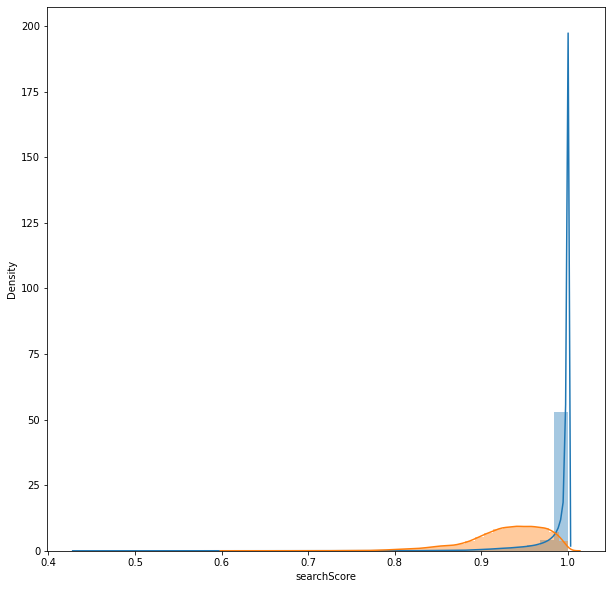

In [22]:
# This plot is for the ditribution of scores of DECOY vs TARGET 

triqler_targets = triqler_peps_df.loc[triqler_peps_df.proteins.str.contains("DECOY") == False]
triqler_decoys = triqler_peps_df.loc[triqler_peps_df.proteins.str.contains("DECOY") == True]

plt.figure(figsize=(10, 10))
sns.distplot(triqler_targets['searchScore'], hist=True, kde=True, 
             bins=int(180/5))
sns.distplot(triqler_decoys['searchScore'], hist=True, kde=True, 
             bins=int(180/5))

In [23]:
#shorten accessions to save memory
def rep_acc(accessions):
    rep_accessions = []
    if set(accessions.split(';')).intersection(conatm_ids):
        return 'contaminant'
    
    for acc in accessions.split(';'):
        if acc.startswith('ENSP'):
            return 'ENSP'
    
    for acc in accessions.split(';'):
        if acc.split('_')[0] in ['altorf', 'pseudo', 'ncRNA', 'DECOY']:
            return 'non_canonical'

    for acc in accessions.split(';'):
        if acc.split(':')[0] in ['COSMIC', 'cbiomut']:
            return 'variant'

    return accessions

In [24]:
triqler_targets['Class'] = triqler_targets['proteins'].apply(rep_acc)

/Users/husen/anaconda3/envs/pgatk/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
triqler_targets.head
triqler_targets['Class'].value_counts()

ENSP             4125497
non_canonical     315085
contaminant        93289
variant            16518
Name: Class, dtype: int64

In [125]:
print('#ENSP seqs', len(set(triqler_targets[triqler_targets['Class']=='ENSP']['peptide'].apply(rep).tolist())))
print('#non_canonical seqs', len(set(triqler_targets[triqler_targets['Class']=='non_canonical']['peptide'].apply(rep).tolist())))
print('#variant seqs', len(set(triqler_targets[triqler_targets['Class']=='variant']['peptide'].apply(rep).tolist())))
print('#non_canonical seqs', len(set(triqler_targets[triqler_targets['Class']=='contaminant']['peptide'].apply(rep).tolist())))

#ENSP seqs 322967
#non_canonical seqs 74001
#variant seqs 5544
#non_canonical seqs 4146


<AxesSubplot:xlabel='Sample'>

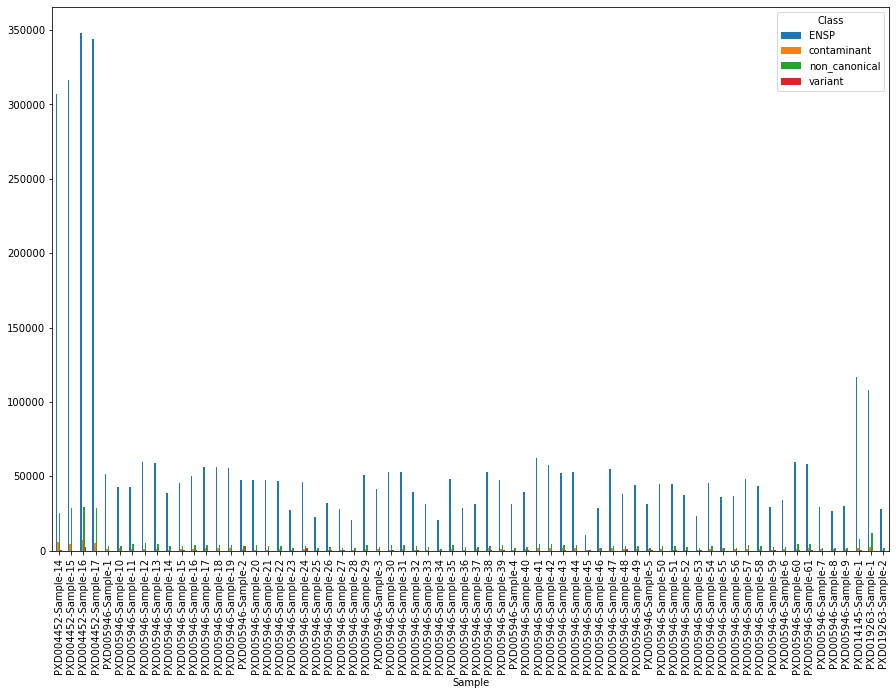

In [27]:
plt.rcParams["figure.figsize"] = [15, 10]
triqler_targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()

In [28]:
triqler_targets.to_csv('all_'+triqler_file_name, sep='\t', index=False)

In [29]:
triqler_noncan_targets = triqler_targets[triqler_targets['Class'].str.contains(r"variant|non_canonical")==True]
triqler_noncan_seqs = list(set([rep(x) for x in triqler_noncan_targets['peptide'].tolist()]))

In [30]:
#get non-canonical peptides that are found in canonical proteins
triqler_found_peps = []
auto = ahocorasick.Automaton()
for noncan_seq in triqler_noncan_seqs:
    auto.add_word(noncan_seq, noncan_seq)
auto.make_automaton()
for canseq in allcan_seqs:
    for end_ind, found in auto.iter(canseq):
        triqler_found_peps.append(found)

In [31]:
triqler_noncan_targets = triqler_noncan_targets[triqler_noncan_targets['peptide'].apply(rep).isin(triqler_found_peps)==False]

<AxesSubplot:xlabel='Sample'>

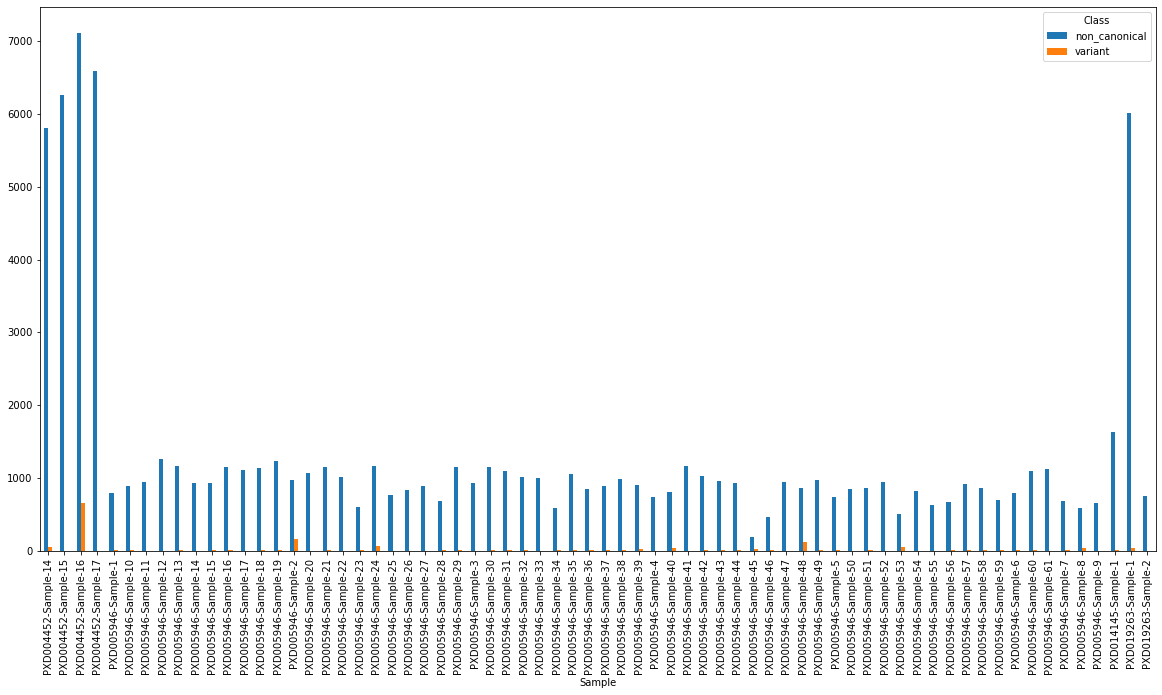

In [32]:
plt.rcParams["figure.figsize"] = [20, 10]
triqler_noncan_targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()

In [33]:
#search for occurence in public repositories ()
def get_counts(seq):
    
    #PGMDB
    gpmdb_response = requests.get('http://rest.thegpm.org/1/peptide/accessions/seq={}'.format(seq))
    gpmdb_species = {'human': 0, 'other': 0}
    pgmdb_count = 0
    for prot, count in gpmdb_response.json().items():
        if 'ENSP' in prot:
            gpmdb_species['human']+=count
        else:
            gpmdb_species['other']+=count
        pgmdb_count += count
    
    #MASSIVE
    massive_url = 'http://massive.ucsd.edu/ProteoSAFe/proxi/v0.1/peptidoforms?resultType=compact&peptideSequence={}'.format(seq)
    massive_result = requests.get(massive_url)
    massive_count = 0
    if massive_result.status_code == 200:
        massive_count = sum([int(d['countPSM']) for d in massive_result.json()])
    
    #PeptideAtlas
    peptideAtlas_url = 'http://www.peptideatlas.org/api/proxi/v0.1/peptidoforms?resultType=compact&peptideSequence={}'.format(seq)
    peptideAtlas_count = 0#sum([int(v) for x,v in requests.get(peptideAtlas_url).json().items()])
    
    sum_scores = pgmdb_count + massive_count + peptideAtlas_count
    #print(sum_scores, pgmdb_count, massive_count, peptideAtlas_count)
    
    return [seq, ','.join(['{}:{}'.format(k,v) for k,v in gpmdb_species.items()]), sum_scores]

seqs_counts = []
for seq in list(set(triqler_noncan_targets.sequence.tolist()[0:5])):
    seqs_counts.append(get_counts(seq))

counts_df = pd.DataFrame(seqs_counts, columns = ['sequence', 'pgmdb_info', 'countsPGMDB|MASSIVE|PepAtlas'])pd.merge(mztab_psms_noncan_targets, counts_df, on='sequence')
len(counts_df)

SyntaxError: invalid syntax (<ipython-input-33-6ae91640a743>, line 35)

In [102]:
'''blastp has to be availble on the system otherwise 
   download blast executables from https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/
   '''

#write the non_canonical peptides to a fasta file
peps = set(triqler_noncan_targets['peptide'].apply(rep).tolist())
query_db = 'non_canonical_peps.fa'
with open(query_db, 'w') as peps_fa:
    for pep in set(peps):
        peps_fa.write('>{}\n{}\n'.format(pep,pep))


In [36]:
makedb_cmd = "makeblastdb -in {blastdb} -dbtype prot".format(blastdb=canonical_proteins_fasta)
os.system(makedb_cmd)

0

In [43]:
runblast_cmd = """blastp \
            -db {blastdb} -query {query_db} -outfmt '6 qseqid sseqid pident qlen slen qstart qend \
            sstart send mismatch positive gapopen gaps qseq sseq evalue bitscore' \
            -num_threads {num_cores} -evalue 10000 -comp_based_stats 0 -ungapped \
            -out {blast_outfile}""".format(blastdb = canonical_proteins_fasta, num_cores = 4, 
                                           query_db=query_db, blast_outfile=query_db+'_blasted')
os.system(runblast_cmd)

0

In [44]:
def parse_blast_output(blast_out_tsv):
    
    blastout={}
    with open(blast_out_tsv, 'r') as blast_out:
        for line in blast_out.readlines():
            row=line.strip().split("\t")
            alignlen=int(row[6])-int(row[5])+1
            category="NA"
            if alignlen==int(row[3]) and float(row[2])==100:
                    blastout[row[0]] = "canonical"
            elif alignlen==int(row[3]) and float(row[2])<100:
                if int(row[12])==0 and int(row[9])==1:
                    blastout[row[0]] = "1aa_missmatch_"+row[1]
                elif int(row[12])==1 and int(row[9])==0:
                    blastout[row[0]] = "1aa_ins_"+row[1]
            elif int(row[3])-alignlen==1 and float(row[2])==100:
                blastout[row[0]] = "1aa_del_"+row[1]
            
    return blastout

In [45]:
blastout = parse_blast_output(query_db+'_blasted')

In [46]:
triqler_noncan_targets['blast_cat'] = np.where(triqler_noncan_targets.peptide.apply(rep).isin(blastout),'onemismatch', 'novel')

In [106]:
print('#PSMs per class:\n', triqler_noncan_targets['Class'].value_counts())
print('\n#unique non_can|var seqs: ', len(set(triqler_noncan_targets['peptide'].apply(rep))))
print('#unique non_can seqs: ', len(set(triqler_noncan_targets[triqler_noncan_targets['Class'] == "non_canonical"]['peptide'].apply(rep))))
print('#unique var seqs: ', len(set(triqler_noncan_targets[triqler_noncan_targets['Class'] == "variant"]['peptide'].apply(rep))))

print('\n#unique non_can and novel seqs: ', len(set(triqler_noncan_targets[ (triqler_noncan_targets['blast_cat']=='novel') & (triqler_noncan_targets['Class'] == "non_canonical")]['peptide'].apply(rep).tolist())))
print('#unique non_can and mismatch seqs: ', len(set(triqler_noncan_targets[ (triqler_noncan_targets['blast_cat']=='onemismatch') & (triqler_noncan_targets['Class'] == "non_canonical")]['peptide'].apply(rep).tolist())))

print('\n#unique variant and novel seqs: ', len(set(triqler_noncan_targets[ (triqler_noncan_targets['blast_cat']=='novel') & (triqler_noncan_targets['Class'] == "variant")]['peptide'].apply(rep).tolist())))
print('#unique variant and mismatch seqs: ', len(set(triqler_noncan_targets[ (triqler_noncan_targets['blast_cat']=='onemismatch') & (triqler_noncan_targets['Class'] == "variant")]['peptide'].apply(rep).tolist())))

#PSMs per class:
 non_canonical    88865
variant           1446
Name: Class, dtype: int64

#unique non_can|var seqs:  44284
#unique non_can seqs:  43501
#unique var seqs:  786

#unique non_can and novel seqs:  36981
#unique non_can and mismatch seqs:  6520

#unique variant and novel seqs:  27
#unique variant and mismatch seqs:  759


In [116]:
len(set(triqler_noncan_targets[triqler_noncan_targets['blast_cat']=='novel']['peptide'].apply(rep).tolist()))

37008

In [109]:
[','.join(x.split(';')) for x in triqler_noncan_targets[triqler_noncan_targets['Class'] == "non_canonical"]['proteins'].tolist()]

['altorf_ENST00000232496.5_3_codon_1;altorf_ENST00000421918.1_1_codon_1;altorf_ENST00000454201.5_1_codon_1',
 'altorf_ENST00000427401.9_1_codon_153;altorf_ENST00000509730.5_1_codon_1;altorf_ENST00000563117.5_1_codon_7;altorf_ENST00000652466.1_1_codon_18;altorf_ENST00000678073.1_3_codon_2;ncRNA_ENST00000436003.3_2_codon_1;ncRNA_ENST00000508363.5_3_codon_34;ncRNA_ENST00000562691.2_3_codon_27;ncRNA_ENST00000567859.5_2_codon_4;ncRNA_ENST00000597642.5_1_codon_6;ncRNA_ENST00000598184.1_2_codon_13;ncRNA_ENST00000670197.1_3_codon_6',
 'altorf_ENST00000394718.4_1_codon_1;altorf_ENST00000435364.8_1_codon_1;altorf_ENST00000464792.2_1_codon_1;altorf_ENST00000676935.1_3_codon_1;altorf_ENST00000677266.1_2_codon_3;altorf_ENST00000677610.1_3_codon_1;altorf_ENST00000678772.1_3_codon_1',
 'altorf_ENST00000258738.10_2_codon_24;altorf_ENST00000361820.6_1_codon_81;altorf_ENST00000404938.6_1_codon_54;altorf_ENST00000406935.5_3_codon_24;altorf_ENST00000443026.6_3_codon_24;pseudo_ENST00000439585.1_2_codon_7',

In [115]:
triqler_noncan_targets[triqler_noncan_targets['peptide']=='EAGAGAEAAAGSARPLGR']

,run,condition,charge,searchScore,intensity,peptide,proteins,Sample,Class,blast_cat
65853,15,A549,2,0.9999200095,1.91294e08,EAGAGAEAAAGSARPLGR,altorf_ENST00000331134.11_3_codon_1;altorf_ENS...,PXD004452-Sample-14,non_canonical,novel
65854,15,A549,3,0.99999507894,7.322994e08,EAGAGAEAAAGSARPLGR,altorf_ENST00000331134.11_3_codon_1;altorf_ENS...,PXD004452-Sample-14,non_canonical,novel
71360,15,HEK293,2,0.9601823,1.040095e08,EAGAGAEAAAGSARPLGR,altorf_ENST00000331134.11_3_codon_1;altorf_ENS...,PXD004452-Sample-15,non_canonical,novel
71361,15,HEK293,3,0.9999547601,1.209512e08,EAGAGAEAAAGSARPLGR,altorf_ENST00000331134.11_3_codon_1;altorf_ENS...,PXD004452-Sample-15,non_canonical,novel
71362,16,HEK293,2,0.9999674599,5.10765e07,EAGAGAEAAAGSARPLGR,altorf_ENST00000331134.11_3_codon_1;altorf_ENS...,PXD004452-Sample-15,non_canonical,novel
71363,16,HEK293,3,0.9999490106,1.944518e08,EAGAGAEAAAGSARPLGR,altorf_ENST00000331134.11_3_codon_1;altorf_ENS...,PXD004452-Sample-15,non_canonical,novel
73717,15,HTC116,2,0.999088928,2.215617e08,EAGAGAEAAAGSARPLGR,altorf_ENST00000331134.11_3_codon_1;altorf_ENS...,PXD004452-Sample-16,non_canonical,novel
73718,15,HTC116,3,0.99999887474,1.116725e09,EAGAGAEAAAGSARPLGR,altorf_ENST00000331134.11_3_codon_1;altorf_ENS...,PXD004452-Sample-16,non_canonical,novel
72803,15,SH-SY5Y,2,0.999869289,7.21898e07,EAGAGAEAAAGSARPLGR,altorf_ENST00000374747.9_2_codon_1,PXD004452-Sample-17,non_canonical,novel
72804,15,SH-SY5Y,3,0.9999748623,3.841499e08,EAGAGAEAAAGSARPLGR,altorf_ENST00000374747.9_2_codon_1,PXD004452-Sample-17,non_canonical,novel
